In [40]:
# !which python
# !pip list | grep tensorflow
# !pip list | grep keras

# import sys
# print("Python executable:", sys.executable)
# print("sys.executable:", sys.executable)
# print("sys.path:", sys.path)

# import tensorflow as tf
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# print("TensorFlow version:", tf.__version__)
# Install necessary libraries
# %pip install tensorflow scikit-learn imbalanced-learn pandas matplotlib

import tensorflow as tf

# List physical and logical devices for 'MPS'
physical_mps = tf.config.list_physical_devices('MPS')
logical_mps = tf.config.list_logical_devices('MPS')
print("Physical MPS devices:", physical_mps)
print("Logical MPS devices:", logical_mps)

import os
# Ensure the environment variable is set BEFORE importing TensorFlow
os.environ['TF_ENABLE_MPS_FALLBACK'] = '1'


tf.debugging.set_log_device_placement(True)

# Run a test operation
a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
c = tf.matmul(a, b)
print("Result:", c.numpy())

Physical MPS devices: []
Logical MPS devices: []
Result: [[1. 3.]
 [3. 7.]]


In [41]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For data splitting, scaling, and class weighting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# For oversampling
from imblearn.over_sampling import SMOTE

# For deep learning model (using TensorFlow/Keras)
import tensorflow as tf

import joblib

# Verify GPU Availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs available:", tf.config.list_physical_devices('GPU'))

# Configure TensorFlow to Use the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

# Step 2: Load the dataset (update file path as needed)
file_path = "C:\\Users\\mrroo\\Downloads\\archive\\02-15-2018.csv"
df = pd.read_csv(file_path)
# Preview the dataset
print(df.head())
print(df.info())
print(df['Label'].value_counts())

# Step 3: Data Cleaning (drop duplicates and missing values)
df = df.drop_duplicates()
df = df.dropna()

# (Optional) If needed, parse the Timestamp column (not used here)
# df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S')
# If the data should be sorted by time:
# df = df.sort_values('Timestamp')

Num GPUs Available:  0
GPUs available: []
   Dst Port  Protocol            Timestamp  Flow Duration  Tot Fwd Pkts  \
0         0         0  15/02/2018 08:25:18      112641158             3   
1        22         6  15/02/2018 08:29:05       37366762            14   
2     47514         6  15/02/2018 08:29:42            543             2   
3         0         0  15/02/2018 08:28:07      112640703             3   
4         0         0  15/02/2018 08:30:56      112640874             3   

   Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  \
0             0                0                0                0   
1            12             2168             2993              712   
2             0               64                0               64   
3             0                0                0                0   
4             0                0                0                0   

   Fwd Pkt Len Min  ...  Fwd Seg Size Min  Active Mean     Active Std  \
0            

In [42]:
# Step 4: Select features and label
features = ['Flow Duration', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Pkt Size Avg', 'Flow IAT Mean']
X = df[features]
y = df['Label']   # Expected values: "Benign", "DDoS-GoldenEye", "DDoS-Slowloris"

# Step 5: Encode labels to numeric values
le = LabelEncoder()
y_encoded = le.fit_transform(y)  
# Now, for example, 0: Benign, 1: DDoS-GoldenEye, 2: DDoS-Slowloris

# Step 6: Scale features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [43]:
# Step 7: Split the data (time-based split to preserve temporal order)
# Here we assume that the data is already ordered by time.
split_index = int(0.8 * len(X_scaled))
X_train = X_scaled[:split_index]
X_test = X_scaled[split_index:]
y_train = y_encoded[:split_index]
y_test = y_encoded[split_index:]

# Step 8: Time-Series Windowing
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size + 1):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size-1])  # label of the last time step in the window
    return np.array(Xs), np.array(ys)

window_size = 10  # Adjust as needed
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

print("Windowed training data shape:", X_train_seq.shape)  # (num_train_samples, window_size, num_features)
print("Windowed test data shape:", X_test_seq.shape)

Windowed training data shape: (832977, 10, 5)
Windowed test data shape: (208238, 10, 5)


In [44]:
# Step 9: Apply SMOTE on the training set
# SMOTE requires 2D data, so reshape the windowed training data:
num_train_samples, win_size, n_features = X_train_seq.shape
X_train_seq_2d = X_train_seq.reshape(num_train_samples, win_size * n_features)

# Apply SMOTE (only on training data)
sm = SMOTE(random_state=42)
X_train_res_2d, y_train_res = sm.fit_resample(X_train_seq_2d, y_train_seq)

# Reshape back to 3D for LSTM input:
X_train_res = X_train_res_2d.reshape(-1, win_size, n_features)
print("After SMOTE, training data shape:", X_train_res.shape)

After SMOTE, training data shape: (2343711, 10, 5)


In [45]:
# Step 10: Compute class weights using the SMOTE-adjusted training labels
classes = np.unique(y_train_res)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_res)
class_weight_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weight_dict)

# Step 11: Convert labels to categorical (one-hot encoding) for training and testing
num_classes = len(classes)  # Should be 3
print("Number of classes:", num_classes)
y_train_cat = to_categorical(y_train_res, num_classes=num_classes)
y_test_cat = to_categorical(y_test_seq, num_classes=num_classes)


Class weights: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0)}
Number of classes: 3


In [46]:
# Step 12: Build the LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, n_features)),
    Dropout(0.2),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\mrroo\Documents\GitHub\RP3-Notebooks\tf-gpu\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,915 (120.76 KB)

 Trainable params: 30,915 (120.76 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# # Step 13: Train the Model with Class Weights
# history = model.fit(
#     X_train_res, 
#     y_train_cat, 
#     epochs=50, 
#     batch_size=128, 
#     validation_split=0.2, 
#     class_weight=class_weight_dict
# )

# Step 12: Select a Subset of the Training Data (10%)
subset_size = int(1* len(X_train_res))
X_train_subset = X_train_res[:subset_size]
y_train_subset = y_train_cat[:subset_size]

# Step 14: Train the Model with Class Weights on the Subset
history = model.fit(
    X_train_subset, 
    y_train_subset, 
    epochs=50, 


    
    batch_size=128, 
    validation_split=0.2, 
    class_weight=class_weight_dict
)


Epoch 1/50
14649/14649 ━━━━━━━━━━━━━━━━━━━━ 85s 6ms/step - accuracy: 0.9709 - loss: 0.0705 - val_accuracy: 0.9951 - val_loss: 0.0182
Epoch 2/50
14649/14649 ━━━━━━━━━━━━━━━━━━━━ 79s 5ms/step - accuracy: 0.9980 - loss: 0.0063 - val_accuracy: 0.9990 - val_loss: 0.0036
Epoch 3/50
14649/14649 ━━━━━━━━━━━━━━━━━━━━ 79s 5ms/step - accuracy: 0.9988 - loss: 0.0037 - val_accuracy: 0.9994 - val_loss: 0.0024
Epoch 4/50
14649/14649 ━━━━━━━━━━━━━━━━━━━━ 79s 5ms/step - accuracy: 0.9990 - loss: 0.0028 - val_accuracy: 0.9996 - val_loss: 0.0024
Epoch 5/50
14649/14649 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - accuracy: 0.9992 - loss: 0.0021 - val_accuracy: 0.9992 - val_loss: 0.0026
Epoch 6/50
14649/14649 ━━━━━━━━━━━━━━━━━━━━ 79s 5ms/step - accuracy: 0.9993 - loss: 0.0019 - val_accuracy: 0.9990 - val_loss: 0.0031
Epoch 7/50
14649/14649 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - accuracy: 0.9994 - loss: 0.0017 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 8/50
14649/14649 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - accuracy: 

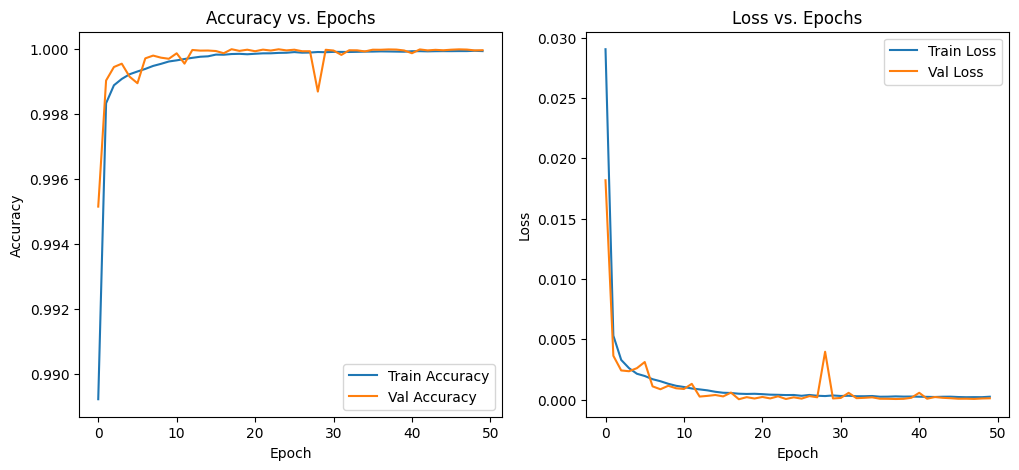

Scaler saved as scaler_sub_100per.pkl
Label encoder saved as label_encoder_sub_100per.pkl
Class weights saved as class_weights_sub_100per.json
Training metrics saved as training_metrics_sub_100per.csv


In [48]:
# Step 14: Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')
plt.savefig('accuracy_vs_epochs.png')  # Save the accuracy plot as PNG

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')
plt.savefig('loss_vs_epochs.png')  # Save the loss plot as PNG

plt.show()

# Define the parameter x
x = 'sub_100per'  # Change this parameter to update the file names

# Create a directory for saving files
save_dir = f'saved_models/{x}'
os.makedirs(save_dir, exist_ok=True)

# Save the model in the latest Keras format
model.save(os.path.join(save_dir, f'lstm_ddos_model_{x}.keras'))

# Save the scaler
joblib.dump(scaler, os.path.join(save_dir, f'scaler_{x}.pkl'))
print(f"Scaler saved as scaler_{x}.pkl")

# Save the label encoder
joblib.dump(le, os.path.join(save_dir, f'label_encoder_{x}.pkl'))
print(f"Label encoder saved as label_encoder_{x}.pkl")

# Convert class weights keys to strings
class_weight_dict_str = {str(k): v for k, v in class_weight_dict.items()}

# Save the class weights
with open(os.path.join(save_dir, f'class_weights_{x}.json'), 'w') as f:
    json.dump(class_weight_dict_str, f)
print(f"Class weights saved as class_weights_{x}.json")

# Save the training and validation metrics to a CSV file
metrics_df = pd.DataFrame(history.history)
metrics_df.to_csv(os.path.join(save_dir, f'training_metrics_{x}.csv'), index=False)
print(f"Training metrics saved as training_metrics_{x}.csv")

In [49]:
# Ensure the input data is reshaped to match the expected input shape of the model
X_test_reshaped = X_test_seq.reshape((X_test_seq.shape[0], window_size, n_features))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_cat)
print(f'Test Loss: {test_loss} - Test Accuracy: {test_accuracy}')

# Save the test metrics to a text file
with open('test_metrics_sub_100per.txt', 'w') as f:
    f.write(f'Test Loss: {test_loss}\n')
    f.write(f'Test Accuracy: {test_accuracy}\n')

6508/6508 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9946 - loss: 0.0503
Test Loss: 0.06769964843988419 - Test Accuracy: 0.9926190376281738
